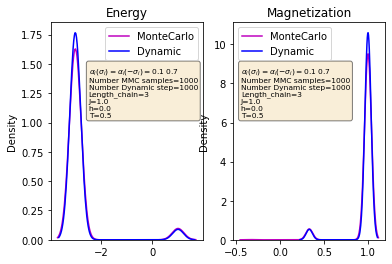

In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy

def magnetization(config):
    return np.mean(config)

def deltaE(h, J, sigma_i, sigma_left, sigma_right):
    dE = 2*h*sigma_i + J*sigma_i*(sigma_left + sigma_right)
    return dE

def metropolis_pass(J, h, beta, config):

    #generate a random order of indices in the range [0, len(config)-1]
    random_order_indices = np.random.permutation(np.arange(len(config)))

    #make the flip of the spin follow the random indices:
    for spin_to_change in random_order_indices:
        sigma_i = config[spin_to_change]
        sigma_left = config[(spin_to_change - 1) % len(config)]
        sigma_right = config[(spin_to_change + 1) % len(config)]

        # evaluate the differency in term of energy when we flip the spin.
        # if we flip a spin the change in energy depends only in the interaction
        # of the two neighbours spins
        dE = deltaE(J, h, sigma_i, sigma_left, sigma_right)

        #metropolis condition
        u = np.random.random()
        if u < min(1, np.exp(-beta * dE)):
            config[spin_to_change] *= -1

    return config

def metropolis_ising(chain_size, J, h, beta, burn_in, correlation_time, n_samples):

    random_seed = 1
    np.random.seed(random_seed)
    current_m = []
    current_H = []

    # generate the first random state
    state = 2 * np.random.randint(2, size=chain_size) - 1

    # delate the first burn_in samples so that the stationary distribution is reached
    for _ in range(burn_in):
        state = metropolis_pass(J, h, beta, state)

    # storage the value of magnetization and energy after the burn_in is expired
    current_m.append(magnetization(state))
    H= 0
    for i in range(len(state)):
        H += -state[i]*(h + (J/2)*(state[(i + 1) % chain_size] + state[(i - 1) % chain_size]))
    current_H.append(H)

    samples = []
    for step in range(n_samples-1):
        state = metropolis_pass(J, h, beta, state)
        samples.append(copy(state))

    #evaluate magnetization and energy over un-correlated samples:
    for step in range(0, n_samples-1, correlation_time):
        H = 0
        current_m.append(magnetization(samples[step]))
        for i in range(len(samples[step])):
            H += -samples[step][i]*(h + (J/2)*(samples[step][(i + 1) % chain_size] + samples[step][(i - 1) % chain_size]))
        current_H.append(H)

    return current_H, current_m

def dynamic_evaluation(chain_size, T, J, h, n_steps, config, action_rates_plus, action_rates_minus):

    random_seed = 1
    np.random.seed(random_seed)
    m = []
    energy = []
    for t in range(n_steps):
        # make the flip of the spin follow the random indices:
        random_order_indices = np.random.permutation(np.arange(chain_size))
        for spin_to_change in random_order_indices:
            sigma_i = config[spin_to_change]
            sigma_left = config[(spin_to_change - 1) % chain_size]
            sigma_right = config[(spin_to_change + 1) % chain_size]
            #compute dE
            dE = deltaE(J, h, sigma_i, sigma_left, sigma_right)
            if sigma_i < 0:
                action_rates_ratio = action_rates_plus[spin_to_change] / action_rates_minus[spin_to_change]
                weight = np.exp(-(1/T) * dE) * action_rates_ratio
                prob_change = action_rates_minus[spin_to_change] * weight/(1 + weight)
            else:
                action_rates_ratio = action_rates_minus[spin_to_change] / action_rates_plus[spin_to_change]
                weight = np.exp(-(1/T) * dE) * action_rates_ratio
                prob_change = action_rates_plus[spin_to_change] * weight/(1 + weight)

            rank = np.random.random()
            if prob_change > rank:
                config[spin_to_change] *= -1
        #I consider the configuration at each pass and not anytime we change one spin to avoid correlation
        m.append(np.mean(config))
        H = 0
        for l in range(len(config)):
            H += -config[l]*(h + (J/2)*(config[(l + 1) % chain_size] + config[(l - 1) % chain_size]))
        energy.append(H)
    return energy, m

if __name__ == '__main__':

    random_seed = 1
    np.random.seed(random_seed)
    chain_size = 3
    time_step = 1500
    J = 1
    h = 0
    T = 0.5
    n_samples = 1000
    n_steps = 1000
    t_burn_in = 10 #int(input("Enter t_burn_in:"))
    t_correlation = 1 #int(input("Enter t_correlation:"))

                ###MONTE CARLO###

    H_MMC, M_MMC = metropolis_ising(chain_size, J, h, 1/T, t_burn_in, t_correlation, n_samples)

                ###ALGORITHM 1###
    # we define action rate plus and minus because the action rates could depend on the fact that the spin is +/-1
    action_rates_plus = []
    action_rates_minus = []
    action_rate_values = [0.1, 0.7]
    separator = " "
    string_action_rate = separator.join([str(_) for _ in action_rate_values])
    for i in range(chain_size):
        for j in range(len(action_rate_values)):
            action_rates_plus.append(action_rate_values[j])
            action_rates_minus.append(action_rate_values[j])

    initial_config = 2 * np.random.randint(2, size=chain_size) - 1
    H, M = dynamic_evaluation(chain_size=chain_size, T=T, J=J, h=h, n_steps=n_steps, config=initial_config,
                              action_rates_plus=action_rates_plus, action_rates_minus=action_rates_minus)

    MMC = {'H_MMC': H_MMC, 'M_MMC': M_MMC}
    df_MMC = pd.DataFrame(data=MMC)
    dynamic = {'H': H, 'M': M}
    df_dynamic = pd.DataFrame(data=dynamic)

    fig_kde, axes = plt.subplots(1, 2)
    h1 = sns.kdeplot(data=df_MMC["H_MMC"], bw_method='scott', color='m', ax=axes[0])
    h1.set(xlabel=None)
    h2 = sns.kdeplot(data=df_dynamic["H"], bw_method='scott', color='b', ax=axes[0])
    h2.set(xlabel=None)
    m1 = sns.kdeplot(data=df_MMC["M_MMC"], bw_method='scott', color='m', ax=axes[1])
    m1.set(xlabel=None)
    m2 = sns.kdeplot(data=df_dynamic["M"], bw_method='scott', color='b', ax=axes[1])
    m2.set(xlabel=None)

    textstr = '\n'.join((
        r'$\alpha_i(\sigma_i) = \alpha_i(-\sigma_i) =$' + string_action_rate,
        r'Number MMC samples=%.0f' % (n_samples,),
        r'Number Dynamic step=%.0f' % (n_steps,),
        r'Length_chain=%.0f' % (chain_size,),
        r'J=%.1f' % (J,),
        r'h=%.1f' % (h,),
        r'T=%.1f' % (T,),))

    axes[0].set_title("Energy")
    axes[0].legend(['MonteCarlo', 'Dynamic'], loc="upper right")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[0].text(0.25, 0.8, textstr, transform=axes[0].transAxes, fontsize=7.5,
                 verticalalignment='top', bbox=props)
    axes[1].set_title("Magnetization")
    axes[1].legend(['MonteCarlo', 'Dynamic'], loc="upper left")
    axes[1].text(0.05, 0.8, textstr, transform=axes[1].transAxes, fontsize=7.5,
                 verticalalignment='top', bbox=props)


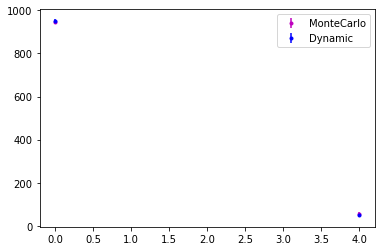

In [62]:
import scipy
from scipy import stats
from collections import defaultdict

def centered_histogram(x,y,J, chain_size, energy_flag):

    if energy_flag == True:
        #rescaling data
        x = [i - min(x) for i in x]
        y = [i - min(y) for i in y]
        if chain_size % 2 != 0:
            bin_center = np.arange(J, max(max(x), max(y)), 2*J)
            bin_center -= J
            bin_bound = np.append(bin_center, bin_center[-1] + 2*J)
        else:
            bin_center = np.arange(J, max(max(x), max(y)), chain_size-1)
            bin_center -= J
            bin_bound = np.append(bin_center, bin_center[-1] + 2 * J)
    else:
        bin_center = np.arange(-1, +1, 2/chain_size)
        bin_bound = np.append(bin_center, bin_center[-1]+2/chain_size)

    counts_x, bins_x = np.histogram(x, bins=bin_bound)
    counts_y, bins_y = np.histogram(y, bins=bin_bound)

    return counts_x, counts_y, bin_bound

def testing(energy, T, n_samples, counts):

    energy = energy - min(energy)
    weights_config = []
    for value in energy:
        weights_config.append(np.exp(-(1/T)*value))
    Z = sum(weights_config)
    config_prob = [weight/Z for weight in weights_config]
    energy = np.sort(energy)
    keys = [str(value) for value in energy]
    values = config_prob
    energy_prob = defaultdict(int)
    for k, n in zip(keys, values):
        energy_prob[k] += n

    binomial_average = []
    binomial_std = []

    for i in range(len(counts)):
        binomial_average.append(scipy.stats.binom.mean(n=n_samples, p=list(energy_prob.values())[i]))
        binomial_std.append(scipy.stats.binom.std(n=n_samples, p=list(energy_prob.values())[i]))

    return binomial_average, binomial_std

if __name__ == '__main__':
    
    counts_HMMC, counts_H, bins_bound = centered_histogram(df_MMC["H_MMC"], df_dynamic["H"], J, chain_size,
                                                           energy_flag=True)
    bins_bound = np.delete(bins_bound, 1)
    plt.errorbar(bins_bound, counts_HMMC, yerr=binom_std_MMC, marker='.', linestyle='none', color='m')
    plt.errorbar(bins_bound, counts_H, yerr=binom_std, marker='.', linestyle='none', color='b')
    plt.legend(['MonteCarlo', 'Dynamic'], loc="upper right")
    plt.show()

    